In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../..')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed', 'dotted']

In [2]:
# trk and jet pt bins
trk_pt_lo = [1, 2, 4, 7]
trk_pt_hi = [2, 4, 7, 20]

jet_pt_lo = [30, 50, 60, 70, 80]
jet_pt_hi = [80, 60, 70, 80, 100]
jet_pt_sel = 0


In [3]:
# file defs

base_dir = "/global/cfs/cdirs/alice/kdevero/"
fs = [base_dir+"PbPb_jet-trk/22850206/merged.root"]
#fs = ["./output_data/temp/merged.root"]
f_names = ["PbPb"]

n_jetpt = "h_jet_pt_JetPt_R0.4_0.15"
n_trkpt = "h_trk_pt_TrkPt_R0.4_0.15"
n_shape_pt = "h_jet-trk_shape_RL_TrkPt_JetPt_R0.4_0.15"
n_shape_z = "h_jet-trk_shape_RL_z_JetPt_R0.4_0.15"
n_ptprofile_pt = "h_jet-trk_ptprofile_RL_TrkPt_JetPt_R0.4_0.15"
n_ptprofile_z = "h_jet-trk_ptprofile_RL_z_JetPt_R0.4_0.15"

n_trkpt_perp = "h_perpcone_trk_pt_TrkPt_R0.4_0.15"
n_shape_pt_perp = "h_perpcone_jet-trk_shape_RL_TrkPt_JetPt_R0.4_0.15"


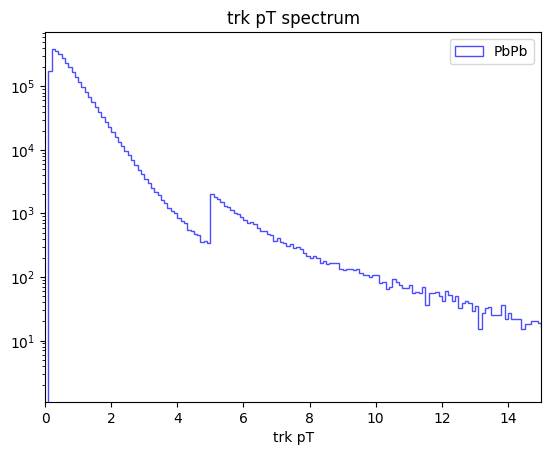

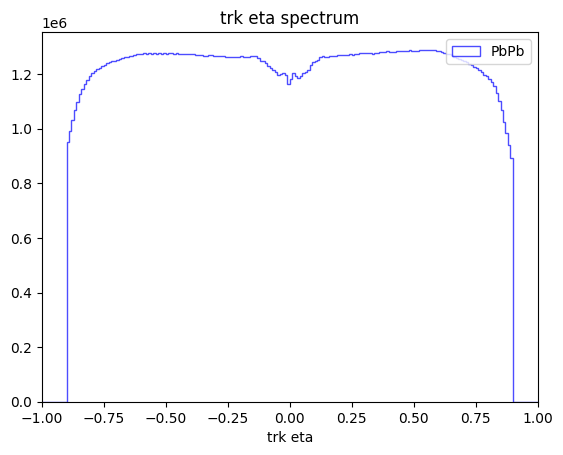

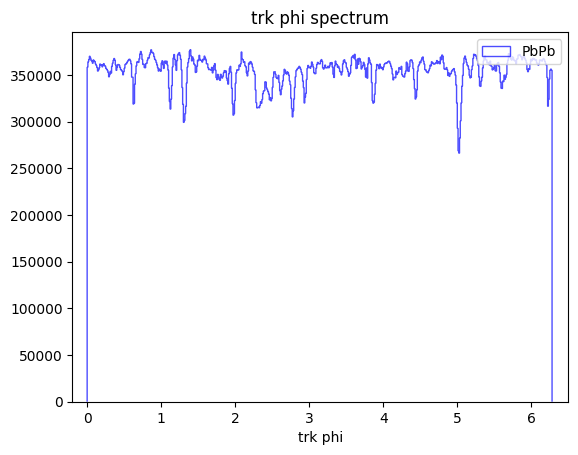

In [4]:
for fi in [0]:
    f = ur.open(fs[fi])

    h = f[n_trkpt]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    this_slice = h.values()
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[fi], color="blue", label=f_names[fi])

plt.legend()
plt.title("trk pT spectrum") 
plt.xlabel('trk pT')
plt.xlim(0, 15)
#plt.ylim(1, 10)
#plt.xscale('log')
plt.yscale('log')
plt.show()

for fi in [0]:
    f = ur.open(fs[fi])

    h = f["hTrackEtaPhi"]
    eta = projectionX(h.values())
    phi = projectionY(h.values())

    eta_edges = h.axis("x").edges()
    plt.hist(eta_edges[:-1], eta_edges, weights=eta, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[fi], color="blue", label=f_names[fi])

    plt.legend()
    plt.title("trk eta spectrum") 
    plt.xlabel('trk eta')
    plt.xlim(-1, 1)
    plt.show()

    phi_edges = h.axis("y").edges()
    plt.hist(phi_edges[:-1], phi_edges, weights=phi, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[fi], color="blue", label=f_names[fi])

    plt.legend()
    plt.title("trk phi spectrum") 
    plt.xlabel('trk phi')
    plt.xlim(-0.2, 6.5)
    plt.show()



0


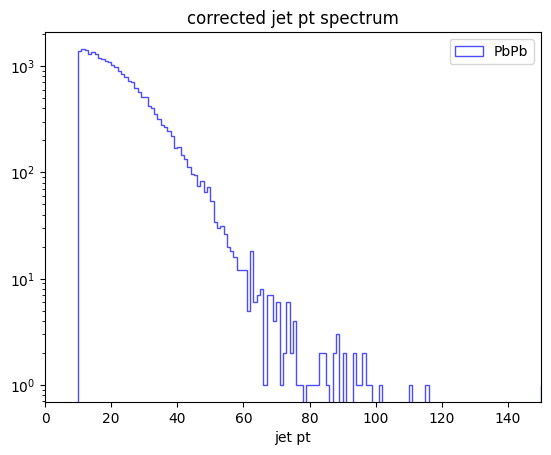

0


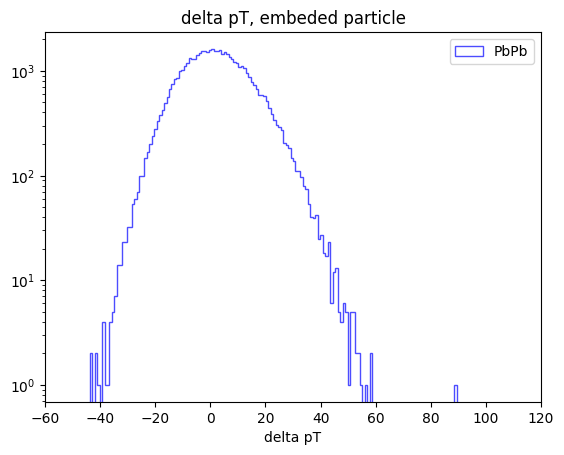

In [5]:
for fi in [0]:
    print(fi)
    f = ur.open(fs[fi])
    
    h = f[n_jetpt]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    this_slice = h.values()
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue", linestyle=L_linestyles[fi], label=f_names[fi])
    
    plt.legend()
    plt.title("corrected jet pt spectrum") 
    plt.xlabel('jet pt')
    plt.xlim(0, 150)
    #plt.xscale('log')
    plt.yscale('log')
plt.show()

for fi in [0]:
    print(fi)
    f = ur.open(fs[fi])
    
    h = f["hDelta_pt"]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    this_slice = h.values()
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue", linestyle=L_linestyles[fi], label=f_names[fi])
    
    plt.legend()
    plt.title("delta pT, embeded particle") 
    plt.xlabel('delta pT')
    plt.xlim(-60, 120)
    #plt.xscale('log')
    plt.yscale('log')
plt.show()
    

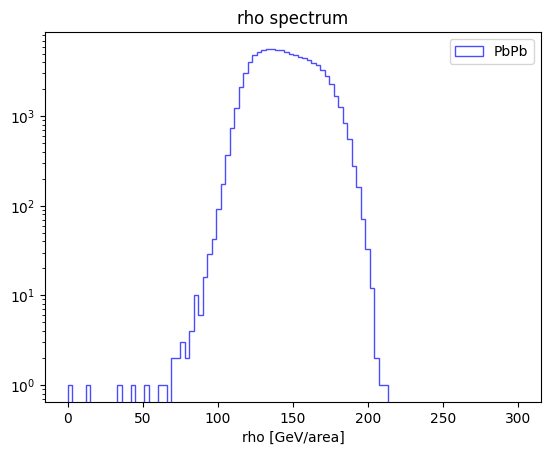

In [6]:
for fi in [0]:
    f = ur.open(fs[fi])
    
    h = f["hRho"]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    this_slice = h.values()
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue", linestyle=L_linestyles[fi], label=f_names[fi])
    
    plt.legend()
    plt.title("rho spectrum") 
    plt.xlabel('rho [GeV/area]')
    #plt.xlim(0, 150)
    #plt.xscale('log')
    plt.yscale('log')
plt.show()


In [7]:
# find number of jets in selected jet pt bin

N_jets = []

for f in fs:
    f = ur.open(f)
    h = f[n_jetpt]
    h_jetpt = h.to_numpy()[0]
    pt_range = (findbin(h.axis("x"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("x"), jet_pt_hi[jet_pt_sel]))
    h_jetpt = h_jetpt[pt_range[0]:pt_range[1]]
    N_jets.append(np.sum(h_jetpt))

print("Njets : " + str(N_jets))



Njets : [4582.0]


(10, 20)
122990.0
(20, 40)
28671.0
(40, 70)
4978.0
(70, 200)
2559.0


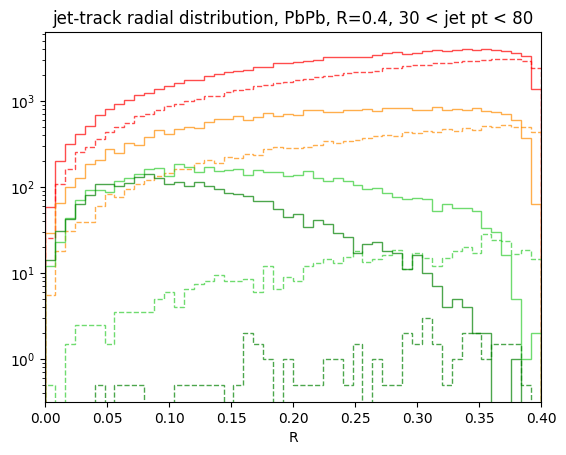

In [8]:
for fi in [0]:
    f = ur.open(fs[fi])
    h = f[n_shape_pt]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    
    pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
    h_numpy = zslice(h.values(), pt_range[0], pt_range[1])

    h_perp = f[n_shape_pt_perp]
    h_numpy_perp = zslice(h_perp.values(), pt_range[0], pt_range[1]) # assumes perp and signal hists exact same binning config
        
    for i in range(len(trk_pt_lo)):
        trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[i]), findbin(h.axis("y"), trk_pt_hi[i]))
        print(trk_pt_range)

        this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
        print(np.sum(this_slice))
        #this_slice = this_slice / (N_jets[fi] * bin_width)

        plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[0], color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))

        this_slice_perp = yslice(h_numpy_perp, trk_pt_range[0], trk_pt_range[1]) / 2
        #this_slice_perp = this_slice_perp / (N_jets[fi] * bin_width * 2) # two cones per signal cone

        plt.hist(bin_edges[:-1], bin_edges, weights=this_slice_perp, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[1], color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))

    #plt.legend(loc='upper left')
    plt.title("jet-track radial distribution, " + f_names[fi] + ", R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
    plt.xlabel('R') 
    plt.xlim(0, 0.4)
    #plt.ylim(0, 0.5)
    plt.yscale("log")

plt.show()

(10, 20)
122990.0
(20, 40)
28671.0
(40, 70)
4978.0
(70, 200)
2559.0


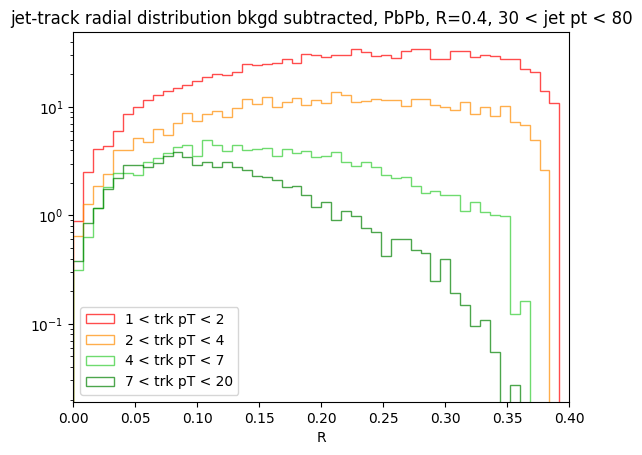

In [9]:
for fi in [0]:
    f = ur.open(fs[fi])
    h = f[n_shape_pt]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    
    h_numpy = h.to_numpy()[0]
    pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
    h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])

    h_perp = f[n_shape_pt_perp]
    h_numpy_perp = zslice(h_perp.to_numpy()[0], pt_range[0], pt_range[1]) # assumes perp and signal hists exact same binning config
    
    for i in range(len(trk_pt_lo)):
        trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[i]), findbin(h.axis("y"), trk_pt_hi[i]))
        print(trk_pt_range)

        this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
        print(np.sum(this_slice))
        this_slice = this_slice / (N_jets[fi] * bin_width)

        this_slice_perp = yslice(h_numpy_perp, trk_pt_range[0], trk_pt_range[1]) / 2
        this_slice_perp = this_slice_perp / (N_jets[fi] * bin_width) # two cones per signal cone

        this_slice_sub = this_slice - this_slice_perp
        plt.hist(bin_edges[:-1], bin_edges, weights=this_slice_sub, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[0], color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))
    
    plt.legend(loc="lower left")
    plt.title("jet-track radial distribution bkgd subtracted, " + f_names[fi] + ", R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
    plt.xlabel('R')
    plt.xlim(0, 0.4)
    plt.yscale("log")
plt.show()

[     0.            494.34569526   1717.29548615   3626.81595838
   6344.40403599   9817.67172007  14140.49944063  18930.94338802
  24145.60124497  29993.95202729  36443.34140018  43673.74161127
  51247.81984375  58638.42206718  66854.03573561  75278.03632654
  83860.24250971  93014.07373135 102664.36773497 112370.1549722
 122538.85710676 132643.89802802 143385.42829889 154266.87819771
 165574.59652926 177000.63938385 188428.73661222 200455.59275143
 212751.77287975 225305.96015762 237970.23979948 250740.6452383
 263650.34581785 276674.22162144 290210.30653825 304230.24565002
 318222.01595485 332149.88725398 346177.07194945 360379.67195138
 375056.26000831 389605.32862769 404426.53951763 419334.64361365
 434465.54196879 449353.5971196  464137.49624455 478561.97496745
 492344.633641  ]


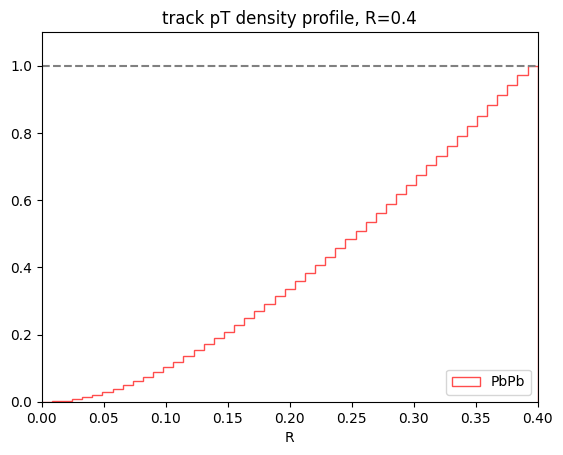

In [10]:
hs = []
for i in range(len(fs)):
    f = ur.open(fs[i])
    h = f[n_ptprofile_pt]
    
    h_numpy = h.to_numpy()[0]
    pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
    h_numpy = projectionX(zslice(h_numpy, pt_range[0], pt_range[1]))

    n_r_bins = 50
    bin_edges = np.linspace(0, 0.4, n_r_bins)
    bin_widths = 0.4 / n_r_bins
    
    h_to_graph = np.array([np.sum(h_numpy[0:findbin(h.axis("x"), bin_edges[i])]) for i in range(n_r_bins-1)])
    print(h_to_graph)
    
    # normalization by inclusive RL selection
    h_to_graph = h_to_graph / h_to_graph[len(h_to_graph)-1]
    hs.append(h_to_graph)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=h_to_graph, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[3*i], label=f_names[i])
    
plt.axhline(1, linestyle='--', color='gray')
plt.legend(loc='lower right')
plt.title("track pT density profile, R=0.4") 
plt.xlabel('R')
plt.xlim(0, 0.4)
plt.ylim(0, 1.1)
plt.show()


(10, 20)
(10, 40)
(10, 70)
(10, 200)


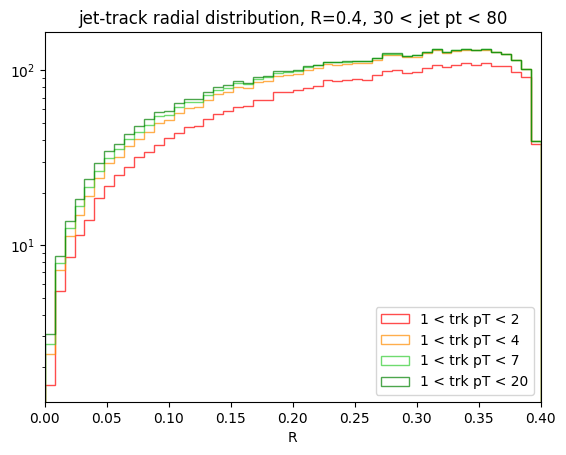

In [11]:
f = ur.open(fs[0])
h = f[n_shape_pt]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

h_numpy = h.to_numpy()[0]
pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])

for i in range(len(trk_pt_lo)):
    trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[0]), findbin(h.axis("y"), trk_pt_hi[i]))
    print(trk_pt_range)
    
    this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
    this_slice = this_slice / (N_jets[fi] * bin_width)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[0], trk_pt_hi[i]))
    
plt.legend(loc='lower right')
plt.title("jet-track radial distribution, R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
plt.xlabel('R')
plt.yscale("log")
plt.xlim(0, 0.4)
#plt.ylim(5e2, 2e5)
plt.show()

(10, 20)
(10, 40)
(10, 70)
(10, 200)


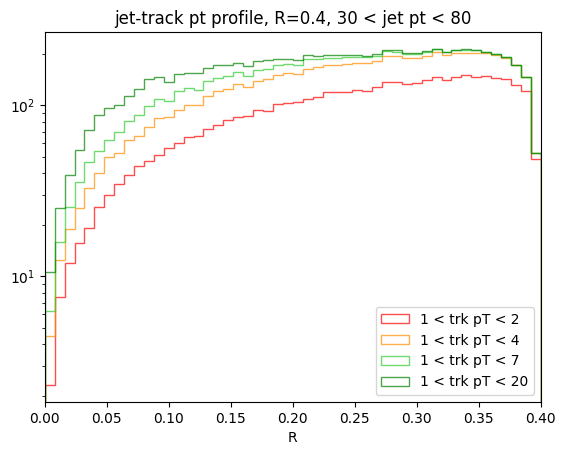

In [12]:
f = ur.open(fs[0])
h = f[n_ptprofile_pt]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

h_numpy = h.to_numpy()[0]
pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])

for i in range(len(trk_pt_lo)):
    trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[0]), findbin(h.axis("y"), trk_pt_hi[i]))
    print(trk_pt_range)
    
    this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
    this_slice = this_slice / (N_jets[fi] * bin_width)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[0], trk_pt_hi[i]))
    
plt.legend(loc='lower right')
plt.title("jet-track pt profile, R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
plt.xlabel('R')
plt.yscale("log")
plt.xlim(0, 0.4)
#plt.ylim(5e2, 2e5)
plt.show()
